In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Stocks: Stoxx 50 Europe

In [2]:
stoxx50E = pd.read_csv('stoxx50.csv')
stoxx50E['Date'] = pd.to_datetime(stoxx50E['Date'])
stoxx50E['YEAR_MONTH'] = stoxx50E['Date'].dt.to_period('M')
stoxx50E['EURO STOXX 50'] = stoxx50E['EURO STOXX 50'].astype(float)
stoxx50E = stoxx50E[
    stoxx50E['YEAR_MONTH'].between('2003-02', '2021-01')
]
stoxx50E.set_index('YEAR_MONTH', inplace=True)
stoxx50E.index = stoxx50E.index.to_timestamp()
stoxx50E.drop(['Date'], axis=1, inplace=True)
stoxx50E.head()

C:\Users\antho\AppData\Local\Temp\ipykernel_258032\3179828065.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stoxx50E['Date'] = pd.to_datetime(stoxx50E['Date'])


,EURO STOXX 50
YEAR_MONTH,
2003-02-01,34801.437310
2003-03-01,33154.249764
2003-04-01,38026.930920
2003-05-01,38403.539812
2003-06-01,40028.099667


In [3]:
stoxx50E['log_returns'] = stoxx50E['EURO STOXX 50'].pct_change()
stoxx50E.dropna(inplace=True)
stoxx50E.head()

,EURO STOXX 50,log_returns
YEAR_MONTH,,
2003-03-01,33154.249764,-0.047331
2003-04-01,38026.930920,0.146970
2003-05-01,38403.539812,0.009904
2003-06-01,40028.099667,0.042302
2003-07-01,41773.387378,0.043602


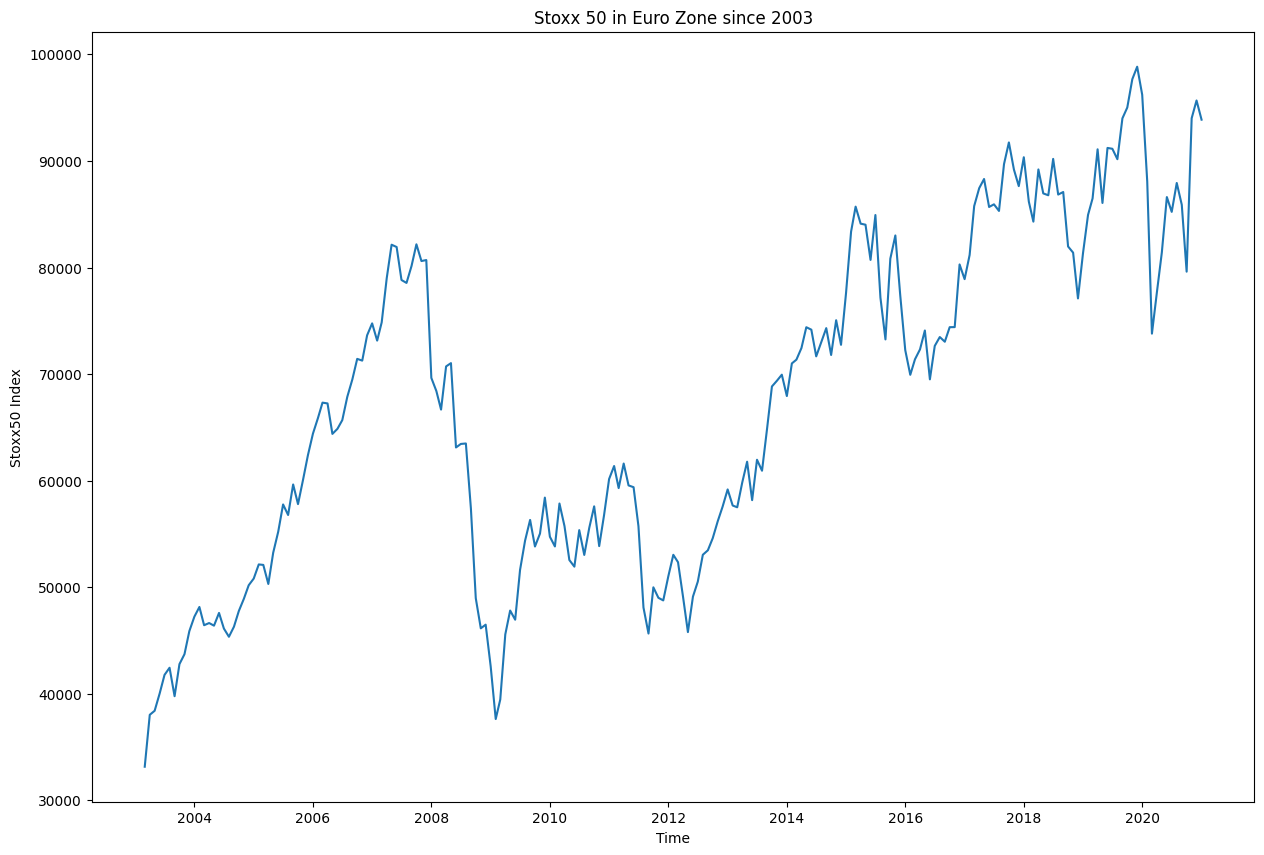

In [4]:
fig = plt.figure(figsize=(15,10))
plt.plot(stoxx50E.index, stoxx50E['EURO STOXX 50'])
plt.xlabel('Time')
plt.ylabel('Stoxx50 Index')
plt.title('Stoxx 50 in Euro Zone since 2003')
plt.show()

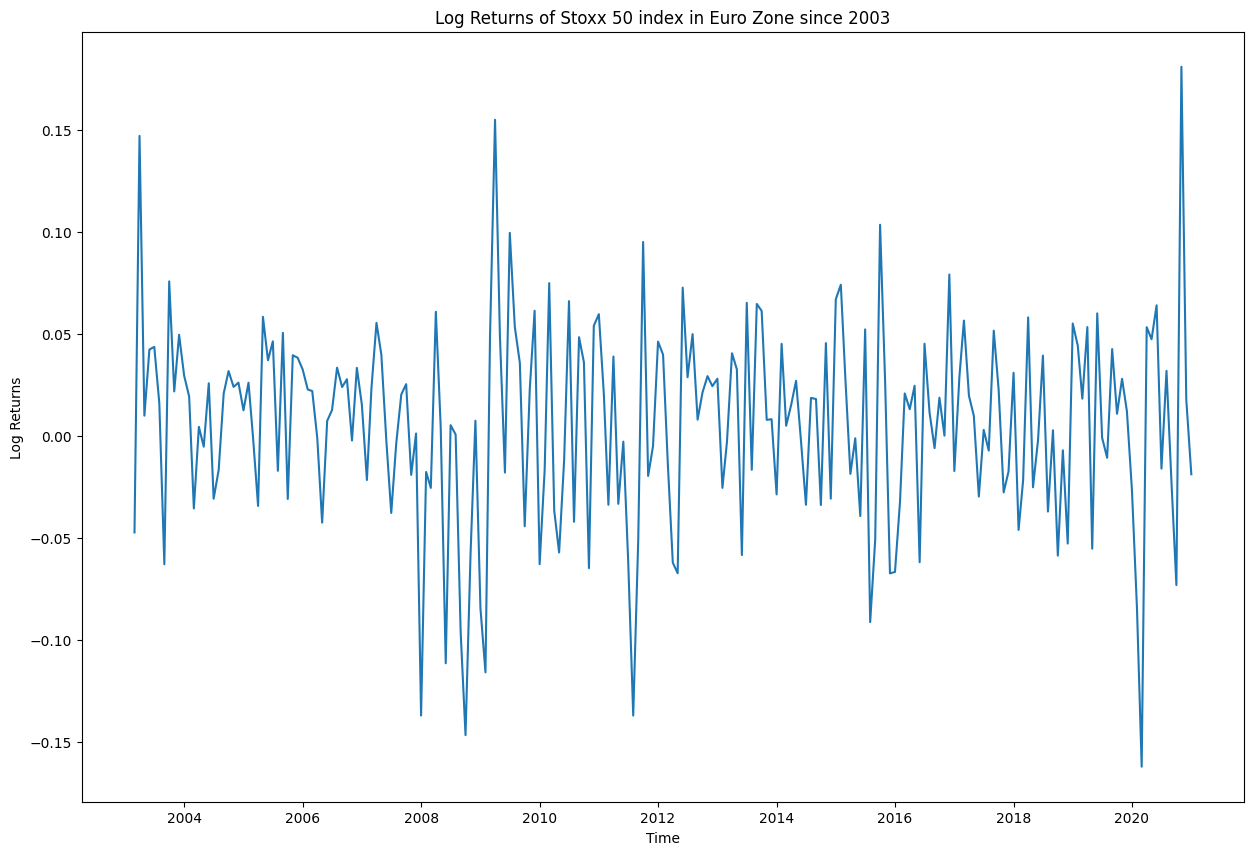

In [5]:
fig = plt.figure(figsize=(15,10))
plt.plot(stoxx50E.index, stoxx50E.log_returns)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Log Returns of Stoxx 50 index in Euro Zone since 2003')
plt.show()

In [6]:
stoxx50E.to_csv('stoxx50E_processed.csv', index=True)

Real Estate: IEIF Index

In [7]:
IEIFIndex = pd.read_csv('IEIF.csv')

IEIFIndex['Date'] = pd.to_datetime(IEIFIndex['Date'], dayfirst=True)

IEIFIndex['Dernier'] = (
    IEIFIndex['Dernier']
    .str.replace('.', '', regex=False)  
    .str.replace(',', '.', regex=False)
    .astype(float)
)
IEIFIndex['YEAR_MONTH'] = IEIFIndex['Date'].dt.to_period('M')

IEIFIndex = IEIFIndex[IEIFIndex['YEAR_MONTH'].between('2003-02', '2021-01')]

IEIFIndex.rename(columns={'Dernier': 'IEIF_index'}, inplace=True)

IEIFIndex.set_index('YEAR_MONTH', inplace=True)
IEIFIndex.index = IEIFIndex.index.to_timestamp()  
IEIFIndex.drop(['Date', 'Ouv.', ' Plus Haut', 'Plus Bas', 'Vol.', 'Variation %'], axis=1, inplace=True)

IEIFIndex.sort_index(inplace=True)
IEIFIndex.head()

,IEIF_index
YEAR_MONTH,
2003-02-01,951.64
2003-03-01,924.22
2003-04-01,959.65
2003-05-01,1014.35
2003-06-01,1003.00


In [8]:
IEIFIndex['log_returns'] = IEIFIndex['IEIF_index'].pct_change()
IEIFIndex.dropna(inplace=True)
IEIFIndex.head()

,IEIF_index,log_returns
YEAR_MONTH,,
2003-03-01,924.22,-0.028813
2003-04-01,959.65,0.038335
2003-05-01,1014.35,0.057000
2003-06-01,1003.00,-0.011189
2003-07-01,1035.16,0.032064


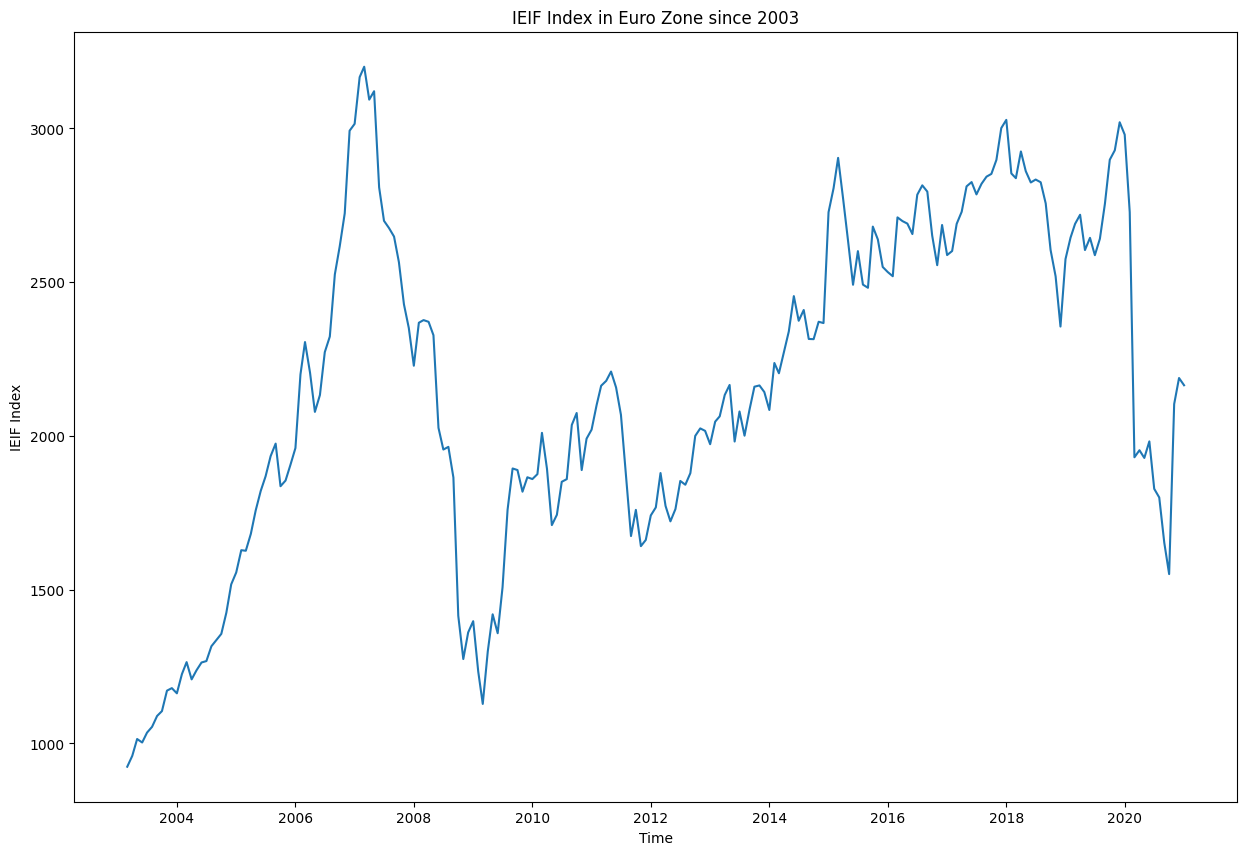

In [9]:
fig = plt.figure(figsize=(15,10))
plt.plot(IEIFIndex.index, IEIFIndex['IEIF_index'])
plt.xlabel('Time')
plt.ylabel('IEIF Index')
plt.title('IEIF Index in Euro Zone since 2003')
plt.show()

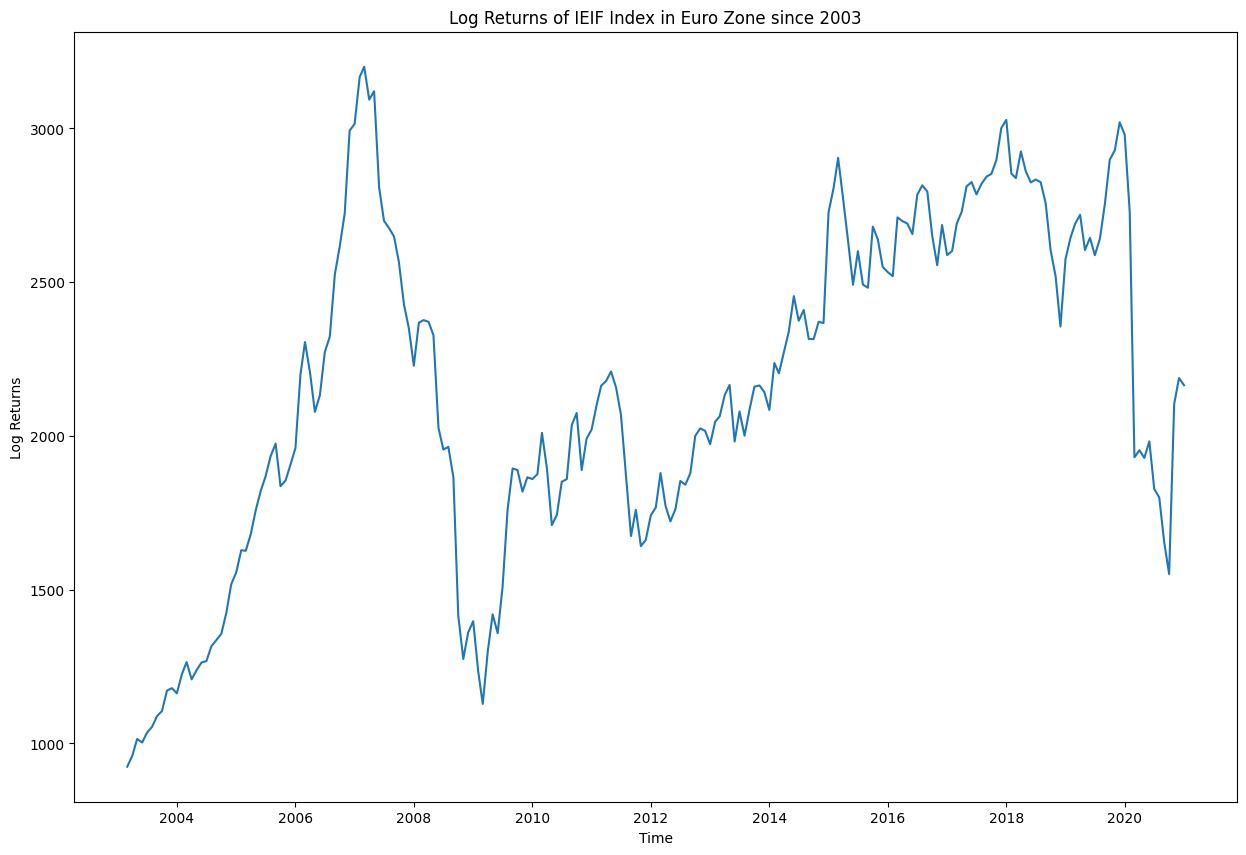

In [10]:
fig = plt.figure(figsize=(15,10))
plt.plot(IEIFIndex.index, IEIFIndex['IEIF_index'])
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Log Returns of IEIF Index in Euro Zone since 2003')
plt.show()

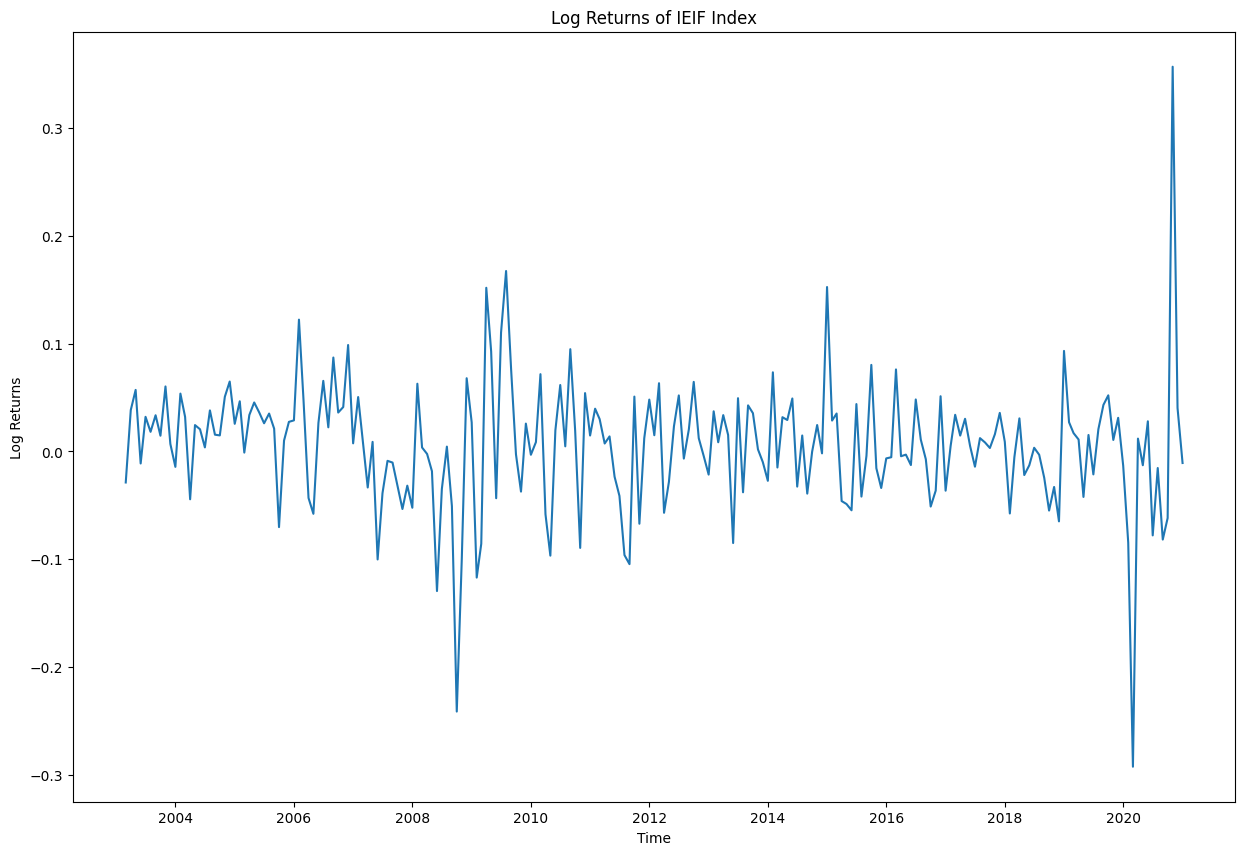

In [11]:
fig = plt.figure(figsize=(15,10))
plt.plot(IEIFIndex.index, IEIFIndex.log_returns)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Log Returns of IEIF Index')
plt.show()

In [12]:
IEIFIndex.to_csv('IEIFindex_processed.csv', index=True)

Modelling

In [13]:
class BlackScholes:
    """
    Black–Scholes model for asset prices using the closed-form discretization.
    
    S_{t+1} = S_t * exp((μ - 0.5σ²) dt + σ √(dt) ε_t).
    """
    def __init__(self, mu=None, sigma=None):
        self.mu = mu
        self.sigma = sigma
        self.calibrated = False

    def calibrate(self, log_returns, dt):
        """
        Calibrate mu and sigma from historical prices using log-returns.
        
        Let r = ln(S_t/S_{t-1}) ~ N((μ - 0.5σ²) dt, σ² dt).
        Then:
          σ = sqrt(var(r) / dt)
          μ = (mean(r)/dt) + 0.5 σ².
        """
        sigma_est = np.sqrt(np.var(log_returns, ddof=1) / dt)
        mu_est = (np.mean(log_returns) / dt) + 0.5 * sigma_est**2
        self.mu = mu_est
        self.sigma = sigma_est
        self.calibrated = True
        return mu_est, sigma_est

    def simulate(self, S0, T, num_steps, num_paths):
        """
        Simulate asset prices using Black–Scholes model (stochastic).
        """
        dt = T / num_steps
        S = np.zeros((num_steps+1, num_paths))
        S[0, :] = S0
        for t in range(1, num_steps+1):
            dW = np.random.normal(0, 1, num_paths)
            S[t, :] = S[t-1, :] * np.exp((self.mu - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * dW)
        return S

    def simulate_deterministic(self, S0, T, num_steps, num_paths):
        """
        Simulate the deterministic part (no noise) of the Black–Scholes model.
        
        S_{t+1} = S_t * exp((μ - 0.5σ²) dt).
        """
        dt = T / num_steps
        S = np.zeros((num_steps+1, num_paths))
        S[0, :] = S0
        for t in range(1, num_steps+1):
            S[t, :] = S[t-1, :] * np.exp((self.mu - 0.5 * self.sigma**2) * dt)
        return S

    def plot_paths(self, time_axis, simulated_paths, average=None, deterministic=None, calibration_data=None):
        """
        Plot simulated asset paths along with the average and optionally the deterministic forecast
        and calibration data.
        """
        plt.figure(figsize=(10, 6))
        plt.title("Black–Scholes Model - Simulated Asset Paths")
        plt.xlabel("Time (years)")
        plt.ylabel("Asset Price")
        num_paths = simulated_paths.shape[1]
        for i in range(num_paths):
            plt.plot(time_axis, simulated_paths[:, i], lw=0.8, alpha=0.3, color='blue')
        if average is not None:
            plt.plot(time_axis, average, color='black', linestyle='--', lw=3, label='Average (Stochastic)')
        if deterministic is not None:
            plt.plot(time_axis, np.mean(deterministic, axis=1), color='green', linestyle='-', lw=3, label='Deterministic')
        if calibration_data is not None:
            calibration_data = np.asarray(calibration_data)
            if len(calibration_data) != len(time_axis):
                obs_time = np.linspace(time_axis[0], time_axis[-1], len(calibration_data))
                calibration_data = np.interp(time_axis, obs_time, calibration_data)
            plt.plot(time_axis, calibration_data, color='red', linestyle='-', lw=2, label='Real Data')
        plt.legend()
        plt.show()

Stocks

In [14]:
stoxx50E_data = stoxx50E.log_returns.values

In [15]:
dt = 1/12  
black_scholes_stocks = BlackScholes()
mu_stock, sigma_stock = black_scholes_stocks.calibrate(stoxx50E_data, dt)

print("\nStock GBM parameters:")
print(f"Drift (mu)     = {mu_stock:.4f}")
print(f"Volatility (σ) = {sigma_stock:.4%}")


Stock GBM parameters:
Drift (mu)     = 0.0852
Volatility (σ) = 17.2197%


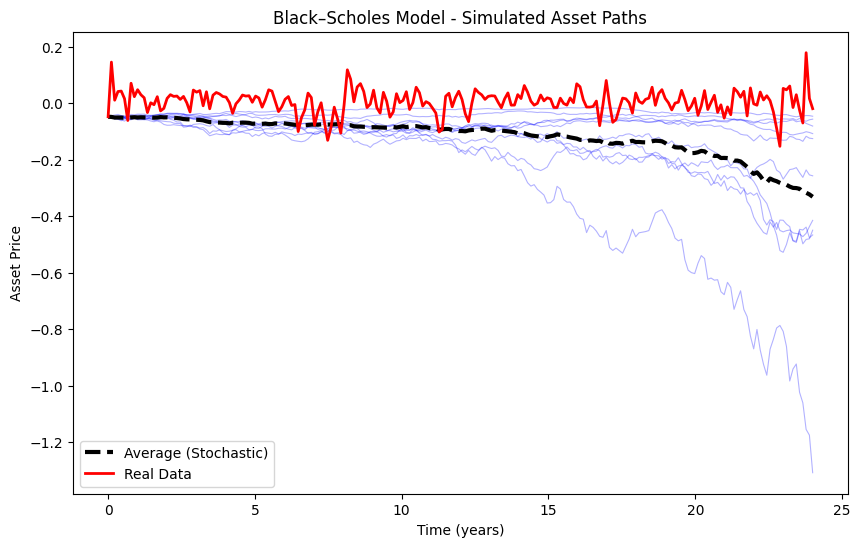

In [16]:
r0 = stoxx50E.iloc[0]['log_returns']
T = 24
num_steps = len(stoxx50E_data-1) 
num_paths = 10
simulated = black_scholes_stocks.simulate(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated, axis=1)
sigma_sim = np.std(simulated, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

black_scholes_stocks.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, deterministic=None, calibration_data=stoxx50E_data)

In [17]:
residuals_stock = stoxx50E['log_returns'].values - mu_stock

Normality check on residuals

In [18]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_stock)
shapiro_test

ShapiroResult(statistic=0.9715602607978798, pvalue=0.00024788868395577226)

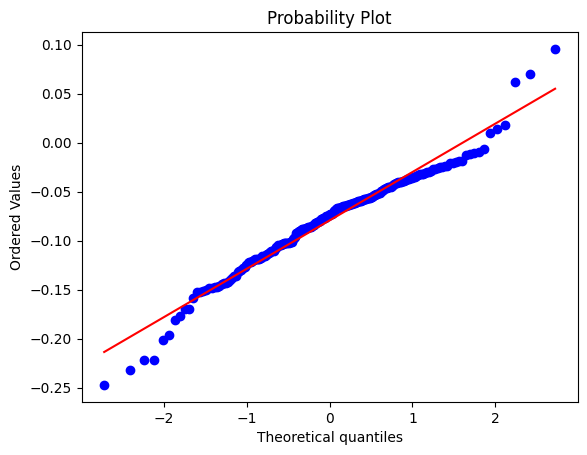

In [19]:
## QQ-Plot against normal distribution

stats.probplot(residuals_stock, dist='norm', plot=plt)
plt.show()

In [20]:
stoxx50E['residuals'] = residuals_stock

stoxx50E.to_csv("stock_residuals.csv", index=True)

Real Estate

In [21]:
IEIFIndex_data = IEIFIndex.log_returns.values

In [22]:
dt = 1/12  
black_scholes_re = BlackScholes()
mu_re, sigma_re = black_scholes_re.calibrate(IEIFIndex_data, dt)

print("\nStock GBM parameters:")
print(f"Drift (mu)     = {mu_re:.4f}")
print(f"Volatility (σ) = {sigma_re:.4%}")


Stock GBM parameters:
Drift (mu)     = 0.0893
Volatility (σ) = 20.7932%


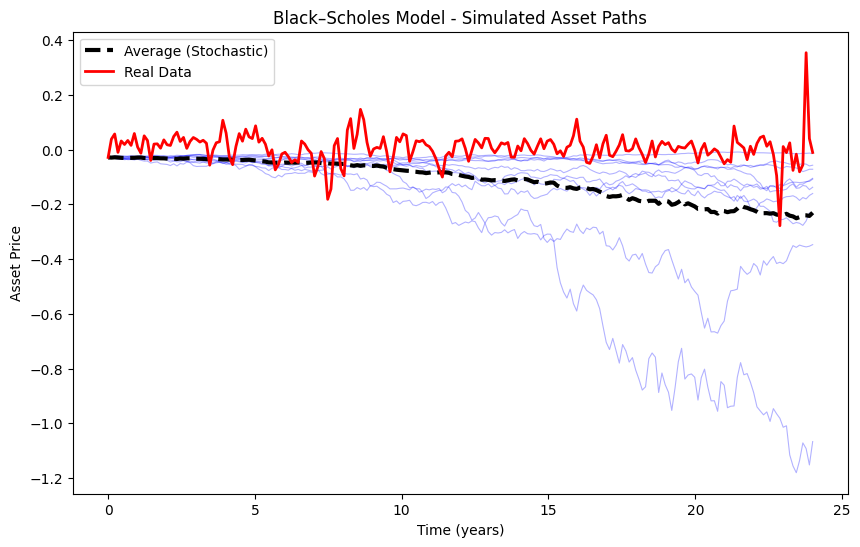

In [23]:
r0 = IEIFIndex.iloc[0]['log_returns']
T = 24
num_steps = len(IEIFIndex_data-1) 
num_paths = 10
simulated = black_scholes_re.simulate(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated, axis=1)
sigma_sim = np.std(simulated, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

black_scholes_re.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, deterministic=None, calibration_data=IEIFIndex_data)

In [24]:
residuals_re = IEIFIndex['log_returns'] - mu_re

Normality check on residuals

In [25]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_re)
shapiro_test

ShapiroResult(statistic=0.896815578897968, pvalue=5.269104347370978e-11)

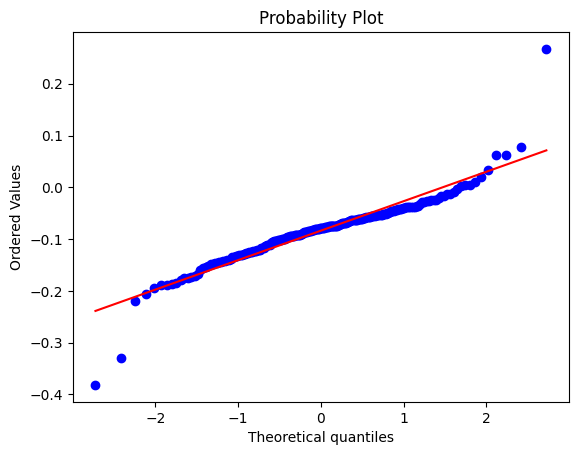

In [26]:
## QQ-Plot against normal distribution

stats.probplot(residuals_re, dist='norm', plot=plt)
plt.show()

In [27]:
IEIFIndex['residuals'] = residuals_re

IEIFIndex.to_csv("real_estate_residuals.csv", index=True)